### Lectura Requerida:

Parte 1a- Detección de Pupila, Canny's Algorithm and Image Gradient

        https://www.researchgate.net/publication/267240432_Deteccion_de_bordes_mediante_el_algoritmo_de_Canny
        
        https://en.wikipedia.org/wiki/Image_gradient
      
    Paper : https://ieeexplore-ieee-org.uchile.idm.oclc.org/stamp/stamp.jsp?tp=&arnumber=6754895
        
Parte 1b - Detección de Iris, Daugman's Iris Detection Algorithm

        http://www.diva-portal.org/smash/get/diva2:831173/FULLTEXT01.pdf
        
    Paper : https://ieeexplore-ieee-org.uchile.idm.oclc.org/stamp/stamp.jsp?tp=&arnumber=6116350
    
Parte 2 - 

### Requirements

In [ ]:
!pip install opencv-python
!pip install google.colab

###Cargar Datos de Multimedia University (MMU1) database

In [ ]:
from google.colab import files
uploaded = files.upload()

In [5]:
!unzip /content/MMUIrisDatabase.zip 

Archive:  /content/MMUIrisDatabase.zip
   creating: /content/imagenes/MMU Iris Database/1/
   creating: /content/imagenes/MMU Iris Database/1/left/
  inflating: /content/imagenes/MMU Iris Database/1/left/aeval1.bmp  
  inflating: /content/imagenes/MMU Iris Database/1/left/aeval2.bmp  
  inflating: /content/imagenes/MMU Iris Database/1/left/aeval3.bmp  
  inflating: /content/imagenes/MMU Iris Database/1/left/aeval4.bmp  
  inflating: /content/imagenes/MMU Iris Database/1/left/aeval5.bmp  
  inflating: /content/imagenes/MMU Iris Database/1/left/Thumbs.db  
   creating: /content/imagenes/MMU Iris Database/1/right/
  inflating: /content/imagenes/MMU Iris Database/1/right/aevar1.bmp  
  inflating: /content/imagenes/MMU Iris Database/1/right/aevar2.bmp  
  inflating: /content/imagenes/MMU Iris Database/1/right/aevar3.bmp  
  inflating: /content/imagenes/MMU Iris Database/1/right/aevar4.bmp  
  inflating: /content/imagenes/MMU Iris Database/1/right/aevar5.bmp  
  inflating: /content/imagenes/

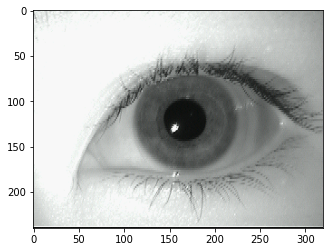

In [4]:
im=cv2.imread('/content/MMU Iris Database/1/left/aeval2.bmp')
plt.imshow(im)

# Parte 1: Detección de Iris

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.ndimage as nd
import time

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving iris1.jpg to iris1.jpg
Saving iris2.jpg to iris2.jpg
Saving iris3.jpg to iris3.jpg
Saving irisCasia.jpg to irisCasia.jpg


### Load Image

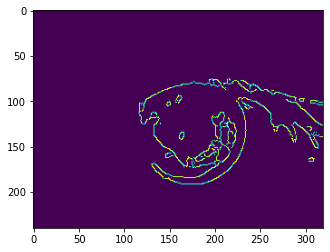

In [37]:
path = '/media/dela/1TB/A Universidad/Electrica/VIII Sem/Procesamiento Digital de Imagenes/IrisRec/IrisRecognition/IrisTestImages/'
image = mpimg.imread(path + 'iris6.bmp')
#image =cv2.imread('/content/irisCasia.jpg')
thresh, binary_image = cv2.threshold(image, 110, maxval=255, type=cv2.THRESH_BINARY)
blurred_image = cv2.GaussianBlur(binary_image, (9,9), 0)
image = cv2.Canny(blurred_image, 100, 200)
plt.imshow(image)

### Pupil Detection
Basado en el paper "A NOVEL APPROACH TO CIRCULAR EDGE DETECTION FOR IRIS IMAGE SEGMENTATION" de Shashidhara H R y Dr. A R Aswath.

Aplica los primeros 4 pasos descritos en el método propuesto y luego, mediante búsqueda rápida, comenzando desde el centro de un eje, determina dos puntos de la circunferencia dada por los métodos previos para encontrar el centro en ese eje. Navega, luego, por el eje contrario en el determinado punto central para determinar el centro en el otro eje y el radio de la circunferencia.

In [338]:
'''Searches for two extreme points in a circumference in a given coordinate x or y. 
Returns the opposite coordinates of the two ends of the a chord parallel to the given axis'''

def borderPoints(image, theresold, coord, axis = 'y', border = 30):
    # image -> np.array, represents the border image
    # theresold -> float [0, 255], represents the theresold value to consider
    # coord -> integer, represents the row/column to navigate with
    # axis -> str, represents the axis to navigate with
    
    startPoint = None
    endPoint = None
    
    if axis == 'y':
        img = image[:, coord]
    else:
        img = image[coord, :]
        
    for i in range(border, img.size - border):
        if img[i] > theresold:
            startPoint = i
            break
        
    for j in range(img.size - border, border, -1):
        if img[j] > theresold:
            endPoint = j
            break
        
    return (startPoint, endPoint)

In [339]:
'''Returns the center coordinates of a circumference.'''

def centerDetect(image, theresold = 100, searchExactPoint = None, axis = 'y', found = False, searchLimit = 10):
    
    if searchExactPoint is None:
        size = (image.shape[1] if axis == 'y' else image.shape[0])
    else:
        startPoint, endPoint = borderPoints(image, theresold, searchExactPoint, axis)
        radii = (endPoint - startPoint)//2
        center = startPoint + radii
        return (center, radii, startPoint is not None, (startPoint, endPoint, searchExactPoint))
    
    # Buscar un punto de referencia en el borde de la circunferencia
    if not found:
        for i in range(2, searchLimit):
            step = size//i
            for j in range(1, i):
                other = step*j
                startPoint, endPoint = borderPoints(image, theresold, other, axis)
                if startPoint is not None:
                    found = True
                    break
        
    radii = (endPoint - startPoint)//2
    center = startPoint + radii
    return (center, radii, found, (startPoint, endPoint, other))

Time (ms): 9.070158004760742


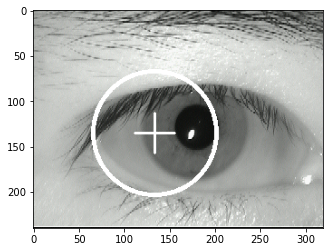

In [340]:
'''Applies the canny detector and center detect to find the iris center and radii.'''

def pupilDetector(img, theresold = 50):
    # img -> scipy.ndimage.ndarray, full color or grayscale image
    
    startTime = time.time()
    
    grayImage = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    thresh, BinaryImage = cv2.threshold(grayImage, theresold, 255, cv2.THRESH_BINARY)
    
    blur = cv2.GaussianBlur(BinaryImage,(5,5), 0) #Gaussian Smoothing, kernel 5x5, standard deviation (x, y) 0
    
    canny = cv2.Canny(blur, 400, 500) #Algoritmo de Canny para la deteccion de bordes, theresold (Hi/Lo) 100/200
    
    center_y, r, f, y_points = centerDetect(canny)
    detectedY = np.copy(canny)
    cv2.circle(detectedY, (y_points[2], y_points[0]), 3, (255, 255, 255), 3)
    cv2.circle(detectedY, (y_points[2], y_points[1]), 3, (255, 255, 255), 3)
    cv2.line(detectedY, (y_points[2], 0), (y_points[2], img.shape[0]), (255, 255, 255), 2)
    cv2.line(detectedY, (0, center_y), (img.shape[1], center_y), (255, 255, 255), 2)
    
    center_x, radii, f, x_points = centerDetect(canny, searchExactPoint = center_y, axis = 'x')
    detectedX = np.copy(canny)
    cv2.circle(detectedX, (x_points[0], x_points[2]), 3, (255, 255, 255), 3)
    cv2.circle(detectedX, (x_points[1], x_points[2]), 3, (255, 255, 255), 3)
    cv2.line(detectedX, (0, x_points[2]), (img.shape[1], x_points[2]), (255, 255, 255), 2)
    cv2.line(detectedX, (center_x, x_points[2]+radii+10), (center_x, x_points[2]-radii-10), (255, 255, 255), 2)
    
    pupil = np.copy(canny)
    cv2.circle(pupil, (center_x, center_y), radii, (255, 255, 255), 3)
    cv2.line(pupil, (center_x+radii//3, x_points[2]), (center_x-radii//3, x_points[2]), (255, 255, 255), 2)
    cv2.line(pupil, (center_x, x_points[2]+radii//3), (center_x, x_points[2]-radii//3), (255, 255, 255), 2)
    
    detectedPupil = np.copy(img)
    cv2.circle(detectedPupil, (center_x, center_y), radii, (255, 255, 255), 3)
    cv2.line(detectedPupil, (center_x+radii//3, x_points[2]), (center_x-radii//3, x_points[2]), (255, 255, 255), 2)
    cv2.line(detectedPupil, (center_x, x_points[2]+radii//3), (center_x, x_points[2]-radii//3), (255, 255, 255), 2)
    
    pupil_coords, pupil_radii = (center_x, center_y), radii
    
    print("Time (ms): {}".format((time.time()-startTime)*1000))
    
    return img, grayImage, BinaryImage, blur, canny, detectedY, detectedX, pupil, detectedPupil, pupil_coords, pupil_radii

img, grayImage, BinaryImage, blur, canny, detectedY, detectedX, pupil, detectedPupil, pupil_coords, pupil_radii = pupilDetector(image)
plt.imshow(detectedPupil, cmap = 'gray')

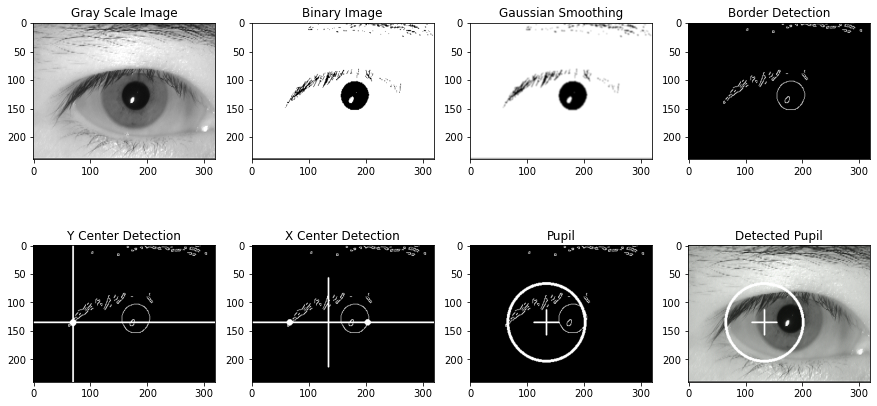

In [341]:
fig=plt.figure(figsize=(15, 15))

fig.add_subplot(2, 4, 1)
imgplot = plt.imshow(grayImage, cmap = 'gray')
plt.title('Gray Scale Image')
fig.add_subplot(2, 4, 2)
imgplot = plt.imshow(BinaryImage, cmap = 'gray')
plt.title('Binary Image')
fig.add_subplot(2, 4, 3)
imgplot = plt.imshow(blur, cmap = 'gray')
plt.title('Gaussian Smoothing')
fig.add_subplot(2, 4, 4)
imgplot = plt.imshow(canny, cmap = 'gray')
plt.title('Border Detection')
fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(detectedY, cmap = 'gray')
plt.title('Y Center Detection')
fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(detectedX, cmap = 'gray')
plt.title('X Center Detection')
fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(pupil, cmap = 'gray')
plt.title('Pupil')
fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(detectedPupil, cmap = 'gray')
plt.title('Detected Pupil')
plt.show()

### Iris Detection
Basado en el paper "FAST AND ACCURATE IRIS SEGMENTATION BASED ON LINEAR BASIS FUNCTION ANDRANSAC" de Kai Wang y Yuntao Qian.

Utiliza el método de búsqueda explicado en el artículo con la diferencia de que el espacio de búsqueda se reduce en base a los datos obtenidos anteriormente.

A diferencia de el documento, ya se conoce un centro aproximado y el radio de la pupila, limitando los radios entre r_pupila y el maximo radio posible dentro de la imagen, definido como la mayor distancia entre el centro bruto y el borde de la imagen en los ejes horizontal y vertical. Esto permite reducir la búsqueda considerablemente, ya que no se navega pixel por pixel y radio por radio. 

Además, debido a que no todo el iris está visible, se define un ángulo con respecto a la horizontal en el cual se hará el barrido.

In [179]:
# irisPreprocessing = np.copy(detectedPupil)

# alpha = 0.25

# a_limit, b_limit = 110, 130
# table = np.zeros(256)
# spectre = range(a_limit, b_limit)

# m = a_limit*(1-alpha)
# beta = (255 - alpha*b_limit + m)/b_limit
# n = b_limit*(alpha - beta) + m

# for i in range(0, 255):
#     if i < a_limit:
#         table[i] = i
#     elif i > b_limit:
#         table[i] = beta*i + n
#     else: 
#         table[i] = 0#alpha*i + m

# for i in range(img.shape[0]):
#     for j in range(img.shape[1]):
#         irisPreprocessing[i, j] = table[irisPreprocessing[i,j]]
        
# irisPreprocessing = irisPreprocessing[:,:,0]
        
# plt.imshow(irisPreprocessing, cmap = 'gray')

In [335]:
### MEJORAR EFICIENCIA ###
### REVISAR, min_size = 40 es demasiado ###
'''Given a pupil, detects the iris using the integrodifferential operator and LBF + Ransac.'''

def irisDetector(img, pupil_coords, pupil_radii, margin = 5, min_iris_size = 30,
                 angle = np.pi/6, rad_margin = 5, experimental = False):
    # image -> np.array, represents the grayscale image
    # pupil_coords -> integer tuple, pupil raw center
    # pupil_radii -> integer, pupil raw radii
    # margin -> integer, search box size around the raw center
    # min_iris_size -> integer, minimum distance between iris and pupil radii
    # angle -> float, max = pi/2
    
    if angle > np.pi/2:
        raise Exception('Angle limit exceeded: Angle value should be in (0, pi/2])')
    
    startTime = time.time()
    
    x_max, y_max = img.shape
    maxRadii = min(pupil_coords[0], x_max - pupil_coords[1], 
                   pupil_coords[1], y_max - pupil_coords[0]) - margin
    
    buffer, X, Y, R = 0, 0, 0, 0
    
    arr = np.zeros((2*margin + 1, 2*margin + 1, maxRadii - pupil_radii - min_iris_size), np.int8)
    
    #Crea un arreglo con los valores medios de cada circunferencia#
    for r in range(pupil_radii + min_iris_size, maxRadii): #Iris DEBE caber en el cuadro
        y_range = int(r*np.sin(angle)) #Limites (max/min) del borde del iris en y
        for i in range(pupil_coords[1] - margin, pupil_coords[1] + margin):
            for j in range(pupil_coords[0] - margin, pupil_coords[0] + margin):
                suma, cnt = 0, 0
                for y in range(-y_range, y_range):
                    x = int(np.sqrt(r**2 - y**2))
                    suma += img[x + i, y + j] + img[i - x, y + j]
                    cnt += 2
                arr[i - pupil_coords[1] + margin, j - pupil_coords[0] + margin, r - pupil_radii - min_iris_size] = suma/cnt
    
    argmax = np.zeros((arr.shape[2], 2))
    maxVal = np.zeros(arr.shape[2])
    
    #Agrega a arreglo argmax las diferencias radiales entre pixeles.#
    for r in range(arr.shape[2]):
        #Consideramos un margen de rad_margin de ancho radial, por lo que hacemos padding equivalente
        val = 0
        #Experimental suma los cambios entre pixeles radiales de paso 1
        if experimental:
            for rad in range(r - rad_margin, r + rad_margin + 1):
                if rad < 0 or rad > arr.shape[2] - 1:
                    val += np.zeros(arr[:,:,r].shape, dtype = 'int8')
                else:
                    val += arr[:,:,rad] - arr[:,:,rad - 1]
        #No experimental ve cambios radiales simetricos a r
        else:
            for i in range(rad_margin + 1):
                if r - i < 0 or r + i > arr.shape[2] - 1:
                    val += np.zeros(arr[:,:,r].shape, dtype = 'int8')
                else:
                    val += arr[:,:,r + i] - arr[:,:,r - i]
        arr_r = val
        argPos = np.argmax(arr_r)
        argmax[r] = (argPos//arr_r.shape[0], int(argPos%arr_r.shape[0])) #Rescato x e y con mayor cambio
        maxVal[r] = arr_r[int(argmax[r][0]), int(argmax[r][1])] #Almaceno el valor maximo, ubicado en x, y
    
    absoluteMax = np.argmax(maxVal)
    x_pos, y_pos = tuple(argmax[absoluteMax])
    
    print("Time (s): {}".format(time.time()-startTime))
        
    return (int(x_pos) + pupil_coords[0] - margin, 
            int(y_pos) + pupil_coords[1] - margin, 
            absoluteMax + pupil_radii + min_iris_size)# + rad_margin)
                
iris = irisDetector(grayImage, pupil_coords, pupil_radii, angle = np.pi/6, rad_margin = 5, experimental=False)

<ipython-input-335-3c3587ecdd1b>:36: RuntimeWarning: overflow encountered in ubyte_scalars
  suma += img[x + i, y + j] + img[i - x, y + j]


Time (s): 1.4897053241729736


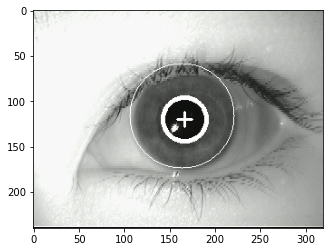

In [336]:
center_x, center_y, radii = iris
detectedIris = np.copy(detectedPupil)
cv2.circle(detectedIris, (center_x, center_y), radii, (255, 255, 255), 1)
plt.imshow(detectedIris, cmap = 'gray')

### Iris Cleaning

Mask: https://stackoverflow.com/questions/44865023/how-can-i-create-a-circular-mask-for-a-numpy-array

In [ ]:
def create_circular_mask(h, w, center, radius, internal = False):
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    mask = dist_from_center <= radius
    if internal:
        mask = dist_from_center >= radius
    return mask

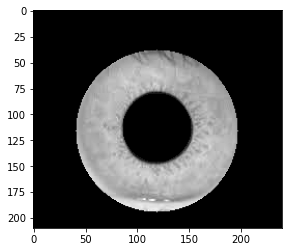

In [ ]:
mask_iris = create_circular_mask(grayImage.shape[0], grayImage.shape[1], (center_x, center_y), radii)
mask_pupil = create_circular_mask(grayImage.shape[0], grayImage.shape[1], pupil_coords, pupil_radii, internal = True)
mask = mask_pupil & mask_iris
irisImage = np.copy(grayImage) * mask
plt.imshow(irisImage, cmap = 'gray')

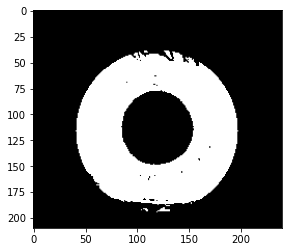

In [ ]:
thresh, binaryIrisMask1 = cv2.threshold(irisImage, 100, 255, cv2.THRESH_BINARY)
thresh, binaryIrisMask2 = cv2.threshold(irisImage, 170, 255, cv2.THRESH_BINARY_INV)
binaryIrisMask = binaryIrisMask1 & binaryIrisMask2
plt.imshow(binaryIrisMask, cmap = 'gray')

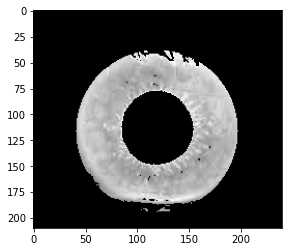

In [ ]:
plt.imshow(irisImage*binaryIrisMask, cmap = 'gray')

In [40]:
np.array([1,2,3,4])-np.array([4,5,6,7])

array([-3, -3, -3, -3])